In [1]:
# import sys
# import gymnasium as gym
# sys.modules["gym"] = gym
import gym
gym.__version__

'0.21.0'

In [2]:
import gnwrapper

In [3]:
import os
import numpy as np
import torch
print(torch.cuda.is_available())

True


In [4]:
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback

In [5]:
env_id = "MountainCarContinuous-v0"
NUM_CPU = 32  # Number of processes to use

In [6]:
# Parallel environments
train_env_f = make_vec_env(env_id, n_envs=NUM_CPU)
train_env_f.observation_space

/home/vlad1slav/Diploma/rl-venv/lib/python3.10/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Box([-1.2  -0.07 -3.  ], [0.6  0.07 3.  ], (3,), float32)

In [8]:
eval_callback = EvalCallback(train_env_f, 
                             best_model_save_path="./logs/best_model/expert",
                             log_path="./logs/results",
                             eval_freq=500,
                             deterministic=True, render=False)
model = PPO("MlpPolicy", 
            train_env_f,
            verbose=1, 
            seed=0,
            batch_size=512,
            # ent_coef=0.00429,
            learning_rate=7.77e-05,
            n_epochs=10,
            n_steps=8*NUM_CPU,
            gae_lambda=0.9,
            gamma=0.9999,
            # clip_range=0.1,
            max_grad_norm=5,
            # vf_coef=0.19,
            use_sde=True,
            # policy_kwargs=dict(log_std_init=-3.29, ortho_init=False),
            tensorboard_log="./logs/ppo_MountainCar_tensorboard_expert/")

model.learn(total_timesteps=1_000_000, callback=eval_callback, progress_bar=True)
model.save("./logs/ppo_MountainCar_expert")

del model # remove to demonstrate saving and loading

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1,005,088/1,000,000  [ 0:01:02 < 0:00:00 , 18,055 it/s ]
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1,005,088/1,000,000  [ 0:01:02 < 0:00:00 , 18,055 it/s ]

In [7]:
# Parallel environments
train_env = make_vec_env(env_id, 
                         env_kwargs=dict(
                            full_obs=False
                         ),
                         n_envs=NUM_CPU)
train_env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [8]:
eval_callback = EvalCallback(train_env, 
                             best_model_save_path="./logs/best_model/expert_noob",
                             log_path="./logs/results",
                             eval_freq=500,
                             deterministic=True, render=False)
model = PPO("MlpPolicy", 
            train_env,
            verbose=1, 
            seed=0,
            batch_size=512,
            # ent_coef=0.00429,
            learning_rate=7.77e-05,
            n_epochs=10,
            n_steps=8*NUM_CPU,
            gae_lambda=0.9,
            gamma=0.9999,
            # clip_range=0.1,
            max_grad_norm=5,
            # vf_coef=0.19,
            use_sde=True,
            # policy_kwargs=dict(log_std_init=-3.29, ortho_init=False),
            tensorboard_log="./logs/ppo_MountainCar_tensorboard_noob/")

model.learn(total_timesteps=1_000_000, callback=eval_callback, progress_bar=True)
model.save("./logs/ppo_MountainCar_noob")

del model # remove to demonstrate saving and loading

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1,002,208/1,000,000  [ 0:01:09 < 0:00:00 , 15,360 it/s ]
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1,002,208/1,000,000  [ 0:01:09 < 0:00:00 , 15,360 it/s ]

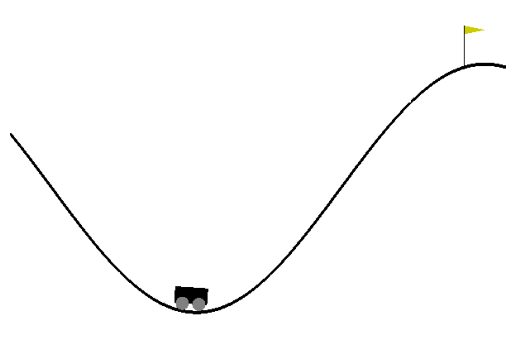

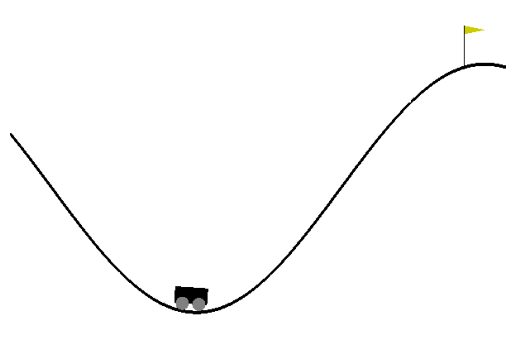

In [9]:
# test_env = gym.make(env_id, render_mode="human")
# test_env = gnwrapper.Animation(test_env)
# test_env = DummyVecEnv([lambda: test_env])

test_env = make_vec_env(env_id,
                        # env_kwargs=dict(
                        #     render_mode="rgb_array"
                        # ),
                        wrapper_class=gnwrapper.Animation,
                        n_envs=1)

expert = PPO.load("./logs/ppo_MountainCar_expert.zip", print_system_info=True)

obs = test_env.reset()

for _ in range(1000):
    action, _states = expert.predict(obs)
    obs, rewards, dones, info = test_env.step(action)
    test_env.render(mode="rgb_array")

    if dones:
        break

test_env.close()

In [12]:
from stable_baselines3.common.evaluation import evaluate_policy

reward, _ = evaluate_policy(expert, test_env, 100)
print(reward)

89.43571804999999


In [13]:
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
import dataclasses

NUM_EPISODES = 10
full_env = gym.make(env_id)
rng = np.random.default_rng()
rollouts = rollout.rollout(
    expert,
    DummyVecEnv([lambda: RolloutInfoWrapper(full_env)]),
    rollout.make_sample_until(min_timesteps=None, min_episodes=100),
    rng=rng,
)

rollouts = [dataclasses.replace(rollout, obs=np.delete(rollout.obs, 2, 1)) for rollout in rollouts]
transitions = rollout.flatten_trajectories(rollouts)

/home/vlad1slav/Diploma/rl-venv/lib/python3.10/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [14]:
print(
    f"""The `rollout` function generated a list of {len(rollouts)} {type(rollouts[0])}.
After flattening, this list is turned into a {type(transitions)} object containing {len(transitions)} transitions.
The transitions object contains arrays for: {', '.join(transitions.__dict__.keys())}."
"""
)

The `rollout` function generated a list of 100 <class 'imitation.data.types.TrajectoryWithRew'>.
After flattening, this list is turned into a <class 'imitation.data.types.Transitions'> object containing 11145 transitions.
The transitions object contains arrays for: obs, acts, infos, next_obs, dones."



In [65]:
from imitation.algorithms import bc
from stable_baselines3.common.policies import ActorCriticPolicy

env = gym.make(env_id, full_obs=False)
env = gnwrapper.Animation(env)
bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=transitions,
    rng=rng,
    # policy=ActorCriticPolicy(observation_space=env.observation_space,
    #                          action_space=env.action_space,
    #                          lr_schedule=lambda _: torch.finfo(torch.float32).max,
    #                          net_arch=[64, 64]
    #                          )
)

In [66]:
bc_trainer.train(n_epochs=2)

0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00142 |
|    entropy        | 1.42     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 34.5     |
|    loss           | 1.42     |
|    neglogp        | 1.42     |
|    prob_true_act  | 0.242    |
|    samples_so_far | 32       |
--------------------------------


273batch [00:00, 708.70batch/s]
425batch [00:00, 733.55batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | -0.00103 |
|    entropy        | 1.03     |
|    epoch          | 1        |
|    l2_loss        | 0        |
|    l2_norm        | 52.9     |
|    loss           | 0.962    |
|    neglogp        | 0.963    |
|    prob_true_act  | 0.433    |
|    samples_so_far | 16032    |
--------------------------------


653batch [00:00, 746.03batch/s]
696batch [00:00, 719.24batch/s]


In [68]:
noob.policy

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (shared_net): Sequential()
    (policy_net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=1, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)

In [69]:
bc_trainer.policy

FeedForward32Policy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (shared_net): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
    )
    (policy_net): Sequential()
    (value_net): Sequential()
  )
  (action_net): Linear(in_features=32, out_features=1, bias=True)
  (value_net): Linear(in_features=32, out_features=1, bias=True)
)

In [67]:
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [71]:
reward, _ = evaluate_policy(bc_trainer.policy, env, 100)
print(f"BC reward: {reward}")

BC reward: 89.60683972004993


In [72]:
noob = PPO.load("./logs/ppo_MountainCar_noob.zip")
reward, _ = evaluate_policy(noob, env, 100)
print(f"PPO reward: {reward}")

PPO reward: 78.004804078344


In [73]:
env_f = gym.make(env_id)
env_f = gnwrapper.Animation(env_f)
env_f.observation_space

Box([-1.2  -0.07 -3.  ], [0.6  0.07 3.  ], (3,), float32)

In [74]:
expert = PPO.load("./logs/ppo_MountainCar_expert.zip")
reward, _ = evaluate_policy(expert, env_f, 100)
print(f"Expert reward: {reward}")

Expert reward: 88.90882646153996
